In [8]:
# import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen,urlretrieve
# from PIL import Image
import tensorflow
# from tqdm import tqdm_notebook
from sklearn.utils import shuffle
import matplotlib
import cv2
from resnets_utils import *

from tensorflow.keras.models import load_model
from sklearn.datasets import load_files
from glob import glob
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
import tensorflow.keras.backend as K
# from skimage.measure import compare_psnr

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [47]:
def unet(input_size = (256,256, 1)):
    inps = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inps)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(3, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inps, outputs = conv10)
    return model

Load Image

(256, 256)


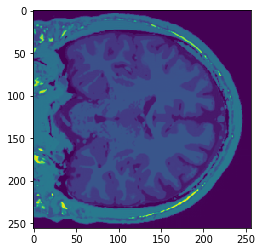

In [56]:
ID = 'C:/Users/attil/Documents/DRS/Datasets/val_data/validating/1CA20.npz'
with np.load(ID) as npzfile:
    x = npzfile['image'] \
        .astype('float32')
img_noisy_np = x[50] / np.max(x[50])
sigma = 25
sigma_ = sigma/255
img_np = img_noisy_np

plt.imshow(img_np)
plt.show()

Setup

In [54]:
INPUT = 'noise'
pad = 'reflection'
OPT_OVER = 'net'

LR = 0.01

show_every = 10
num_iter = 2400

net = unet()
net_input = np.random.normal(size=(1, np.shape(img_np)[0], np.shape(img_np)[1], 1))

Optimize

In [58]:
opt = optimizers.Adam(learning_rate=LR)
net.compile(optimizer = opt, loss = 'mean_squared_error', metrics = ['mean_squared_error'])

# Set up noise
reg_noise_std = 1/30


net_out = net(net_input)
print(np.shape(net_out))
for i in range(num_iter):
    #history = net.train_on_batch(net_input + np.random.normal(0, reg_noise_std, np.shape(img_np)), np.expand_dims(img_np, axis=0))
    history = net.train_on_batch(net_input, np.expand_dims(img_np, axis=0))
    if i%show_every == 0:
        print(history)
        net_out = net(net_input)
        plt.imshow(net_out[0, ...])
        plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



ResourceExhaustedError: OOM when allocating tensor with shape[1,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]